In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

import matplotlib.pyplot as plt

### MNIST Dataset


In [4]:
ROOT = "./data"
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 7300785.69it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 291403.82it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:05<00:00, 316675.29it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [ ]:
# split train/val set

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data, [n_train_examples, n_valid_examples]
)

# compute mean and std and setup transforms
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_trainsforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)
test_trainsforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

train_data.dataset.transform = train_trainsforms
valid_data.dataset.transform = test_trainsforms
test_data.transform = test_trainsforms

In [9]:
# create dataloader
BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

### LeNet


In [ ]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding="same"
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [ ]:
# train function
def train(model, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time

            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            print(f"Time: {elapsed}")
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [ ]:
num_classes = len(train_data.dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(f"Num classes: {num_classes}")

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = "./model"
if not os.path.exists(save_model):
    os.makedirs(save_model)

train_accs = []
train_losses = []
eval_accs = []
eval_losses = []
best_loss_eval = 100

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_acc, train_loss = train(lenet_model, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), save_model + "/lenet_model.pt")

    print("-" * 59)
    print(
        "| End of epoch {:3d} | time: {:5.2f}s | train loss {:5.2f} | train acc {:8.3f} | eval loss {:5.2f} | eval acc {:8.3f}".format(
            epoch,
            time.time() - epoch_start_time,
            train_loss,
            train_acc,
            eval_loss,
            eval_acc,
        )
    )
    print("-" * 59)

    lenet_model.load_state_dict(torch.load(save_model + "/lenet_model.pt"))
    lenet_model.eval()

cuda
Num classes: 10
| epoch   0 |    50/  211 batches | accuracy    0.634
Time: 1.6520195007324219
| epoch   0 |   100/  211 batches | accuracy    0.895
Time: 1.509096384048462
| epoch   0 |   150/  211 batches | accuracy    0.933
Time: 1.4545528888702393
| epoch   0 |   200/  211 batches | accuracy    0.949
Time: 1.4447367191314697
-----------------------------------------------------------
| End of epoch   0 | time:  6.93s | train loss  0.48 | train acc    0.952 | eval loss  0.17 | eval acc    0.946
-----------------------------------------------------------
| epoch   1 |    50/  211 batches | accuracy    0.959
Time: 1.522287368774414
| epoch   1 |   100/  211 batches | accuracy    0.963
Time: 1.4535622596740723
| epoch   1 |   150/  211 batches | accuracy    0.967
Time: 1.4526541233062744
| epoch   1 |   200/  211 batches | accuracy    0.971
Time: 1.4396743774414062
-----------------------------------------------------------
| End of epoch   1 | time:  6.74s | train loss  0.11 | tr

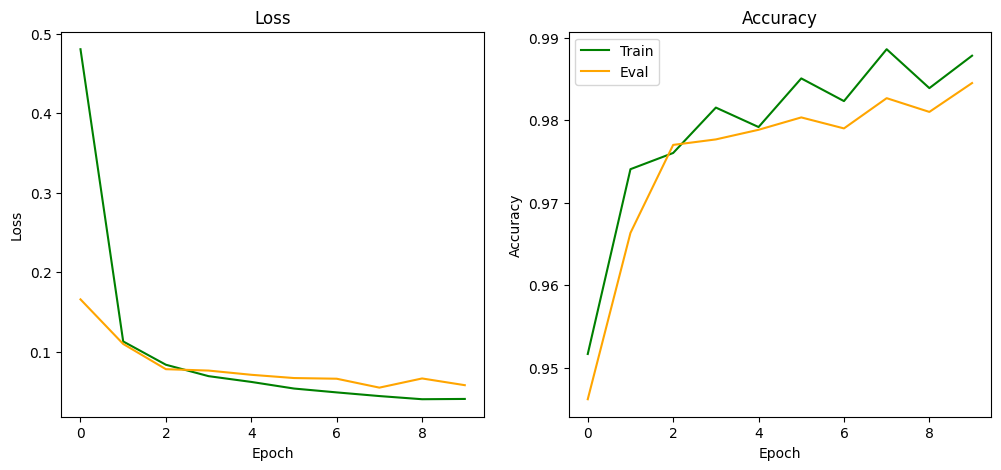

In [ ]:
# visualize the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses, color="green")
ax[0].set(xlabel="Epoch", ylabel="Loss")
ax[0].set_title("Loss")
ax[0].plot(eval_losses, color="orange")

ax[1].plot(train_accs, color="green")
ax[1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1].set_title("Accuracy")
ax[1].plot(eval_accs, color="orange")
plt.legend(["Train", "Eval"])
plt.show()

### Evaluate on test set


In [33]:
test_data.transform = test_trainsforms
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Test accuracy: 0.9877
Test loss: 0.04028264814915019
